In [1]:
#IMPORTING NECESSARY LIBRARIES
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [2]:
#Read training dataset
train_df=pd.read_csv('training.csv')
train_df.head()

C:\Users\riyam\AppData\Local\Temp\ipykernel_5932\214161583.py:2: DtypeWarning: Columns (34,139,154,157,212) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df=pd.read_csv('training.csv')


ID  label  key_Region Id  key_MarketPlace Id    key_ASIN  \
0  34016      0              1                   1  B00YCZ6IKA   
1   3581      0              1                   1  B00U25WT7A   
2  36025      1              1                   1  B011BZ3GXU   
3  42061      1              1                   1  B0089XDG3I   
4  14628      1              1                   1  B014UTSBZW   

       key_Binding Code key_binding_description key_brand_code  \
0               kitchen                 Kitchen          NICLW   
1        office_product          Office Product            NaN   
2  consumer_electronics             Electronics            NaN   
3                    pc      Personal Computers            NaN   
4         miscellaneous                   Misc.          ZUKC7   

   key_case_pack_quantity key_classification_code  ... cand_pkg_weight  \
0                     NaN            base_product  ...        0.529104   
1                     NaN            base_product  ...        0.100000   
2                     NaN            base_product  ...        0.654773   
3                     NaN            base_product  ...        3.549442   
4                     1.0            base_product  ...        0.396832   

  cand_pkg_weight_uom  cand_pkg_width cand_release_date_embargo_level  \
0              pounds        5.118110                             NaN   
1              pounds        4.500000                             NaN   
2              pounds        3.937008                             NaN   
3              pounds       10.314961                             NaN   
4              pounds        5.196850                             NaN   

  cand_dw_creation_date cand_dw_last_updated cand_is_deleted  \
0             18-Apr-13            14-Oct-17               N   
1             19-May-16            21-Mar-18               N   
2             10-Dec-15            16-Feb-18               N   
3             19-Oct-12            15-Feb-18               N   
4             26-Jul-12             9-Mar-18               N   

  cand_last_updated cand_version  cand_external_testing_certification  
0         13-Oct-17         2867                                  NaN  
1         20-Mar-18           65                                  NaN  
2         15-Feb-18         1532                                  NaN  
3         14-Feb-18        13964                                  NaN  
4          9-Mar-18         1253                                  NaN  

[5 rows x 228 columns]

**DATA DESCRIPTION**

In [3]:
train_df.shape

(36803, 228)

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36803 entries, 0 to 36802
Columns: 228 entries, ID to cand_external_testing_certification
dtypes: float64(90), int64(12), object(126)
memory usage: 64.0+ MB


In [5]:
train_df.isnull().sum().sort_values()

ID                                         0
cand_creation_date                         0
cand_ASIN                                  0
cand_MarketPlace Id                        0
cand_Region Id                             0
                                       ...  
cand_recall_notice_expiration_date     36803
cand_recall_notice_publication_date    36803
cand_recall_notice_receive_date        36803
key_number_of_pages                    36803
key_recall_notice_publication_date     36803
Length: 228, dtype: int64

**DATA PREPROCESSING**

In [6]:
#Dropping columns with all missing values
train_df = train_df.dropna(axis=1, how='all')

In [7]:
# Dropping columns with too many missing values (threshold can be adjusted)
missing_threshold=0.7 #70% missing values threshold
threshold = len(train_df) * (1 - missing_threshold)
train_df=train_df.dropna(thresh=threshold, axis=1)

In [8]:
# Fill missing values in remaining columns (numerical columns with mean, categorical columns with mode)
numerical_cols=train_df.select_dtypes(include=['float64']).columns
categorical_cols=train_df.select_dtypes(include=['object']).columns

train_df[numerical_cols] = train_df[numerical_cols].fillna(train_df[numerical_cols].mean())
train_df[categorical_cols] = train_df[categorical_cols].fillna(train_df[categorical_cols].mode().iloc[0])

In [9]:
# Encode categorical variables using Label Encoder
label_encoder = LabelEncoder()
train_df.loc[:, categorical_cols] = train_df.loc[:, categorical_cols].apply(label_encoder.fit_transform)

C:\Users\riyam\AppData\Local\Temp\ipykernel_5932\3285259696.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train_df.loc[:, categorical_cols] = train_df.loc[:, categorical_cols].apply(label_encoder.fit_transform)


In [10]:
# Drop unnecessary columns
unnecessary_columns = ['key_ASIN', 'key_Binding Code', 'key_classification_description', 'cand_ASIN', 'cand_Binding Code', 'cand_classification_description']
train_df = train_df.drop(columns=unnecessary_columns)

In [11]:
#Checking for missing values
missing_values = train_df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 ID                         0
label                      0
key_Region Id              0
key_MarketPlace Id         0
key_binding_description    0
                          ..
cand_dw_creation_date      0
cand_dw_last_updated       0
cand_is_deleted            0
cand_last_updated          0
cand_version               0
Length: 109, dtype: int64


In [12]:
# Check for outliers in numerical columns
numerical_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
numerical_data = train_df[numerical_cols]
numerical_summary = numerical_data.describe()
print("Numerical Summary:\n", numerical_summary)

Numerical Summary:
                  ID         label  key_Region Id  key_MarketPlace Id  \
count  36803.000000  36803.000000        36803.0             36803.0   
mean   26341.493438      0.505095            1.0                 1.0   
std    15159.339391      0.499981            0.0                 0.0   
min        1.000000      0.000000            1.0                 1.0   
25%    13250.500000      0.000000            1.0                 1.0   
50%    26318.000000      1.000000            1.0                 1.0   
75%    39455.500000      1.000000            1.0                 1.0   
max    52576.000000      1.000000            1.0                 1.0   

       key_case_pack_quantity       key_ean  key_fma_qualified_price_max  \
count            36803.000000  3.680300e+04                 36803.000000   
mean                 9.828326  1.704312e+12                   116.134729   
std                 48.864172  2.292264e+12                   259.154812   
min                  0.0000

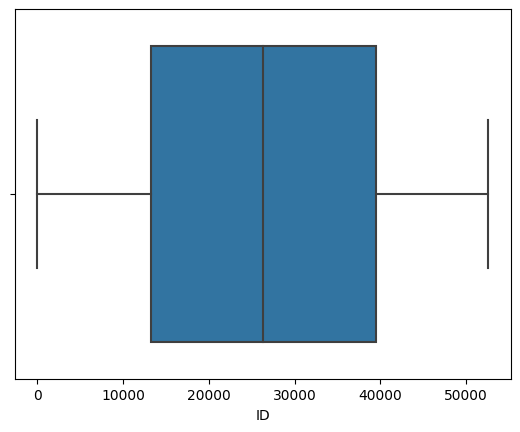

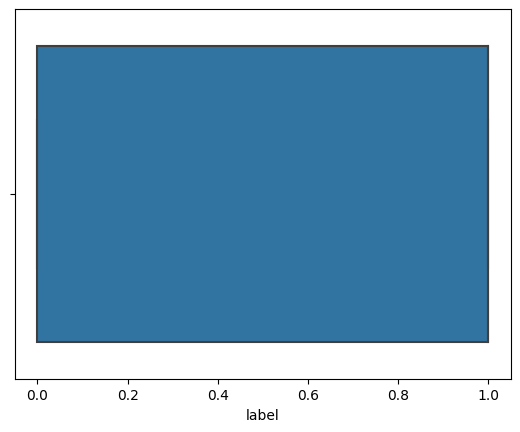

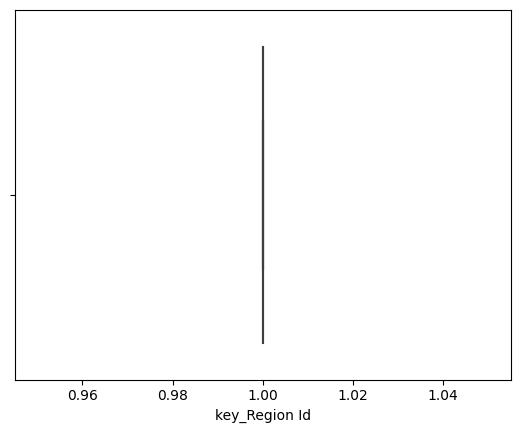

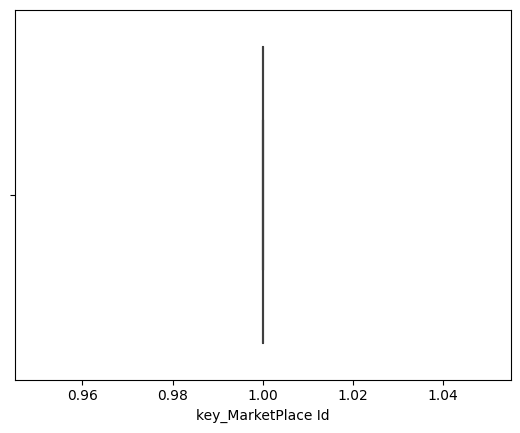

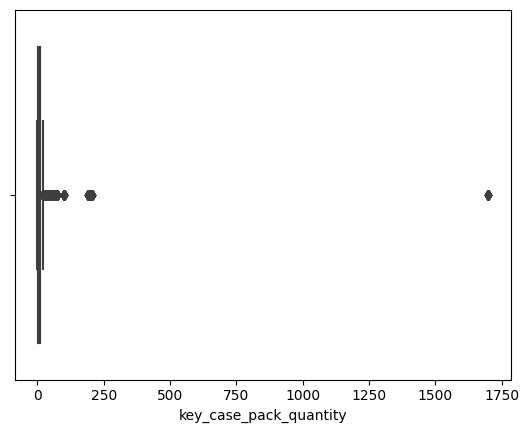

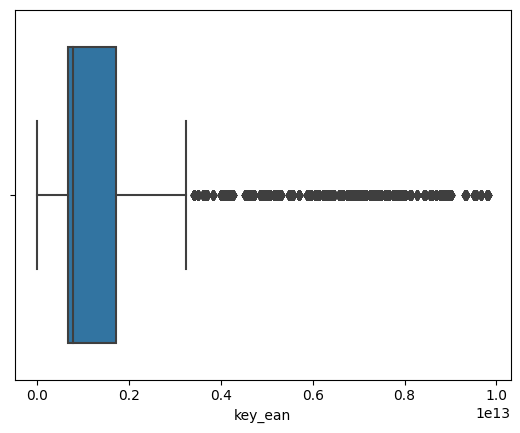

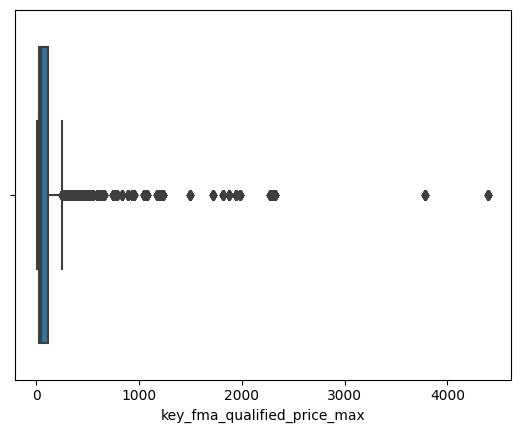

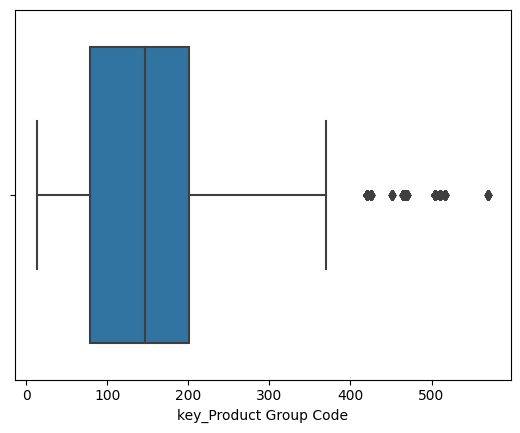

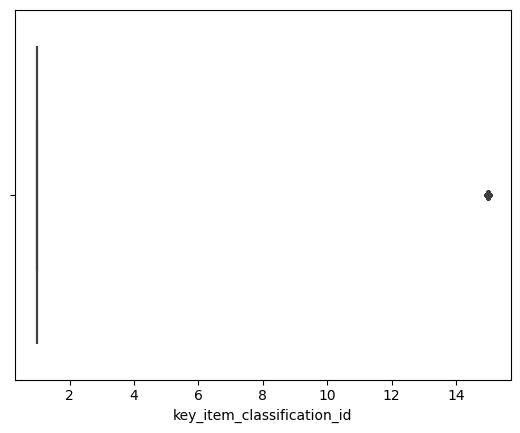

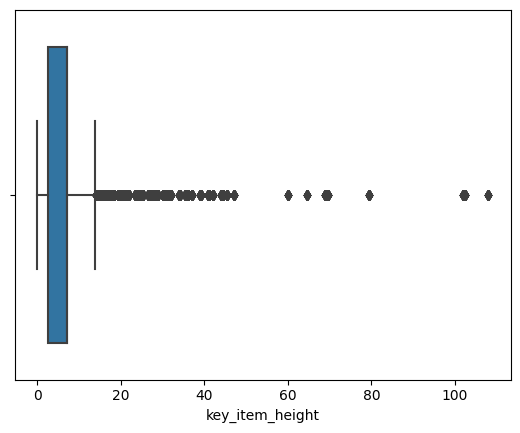

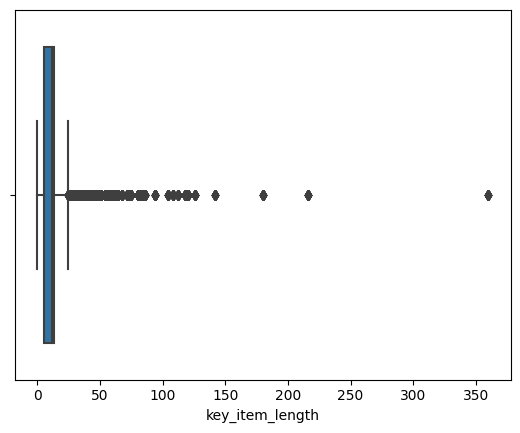

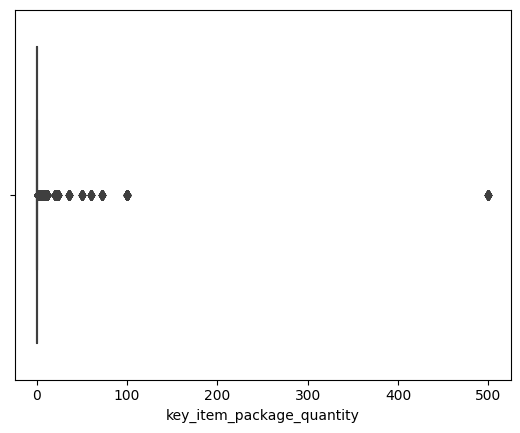

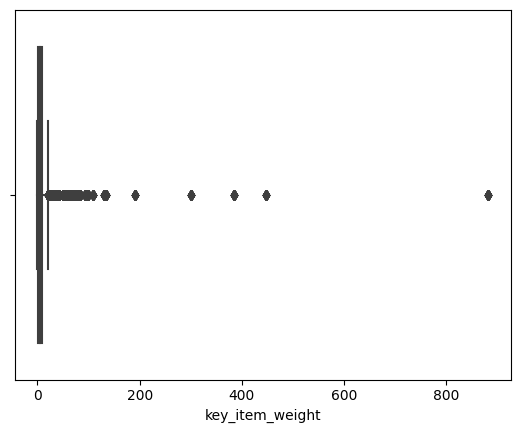

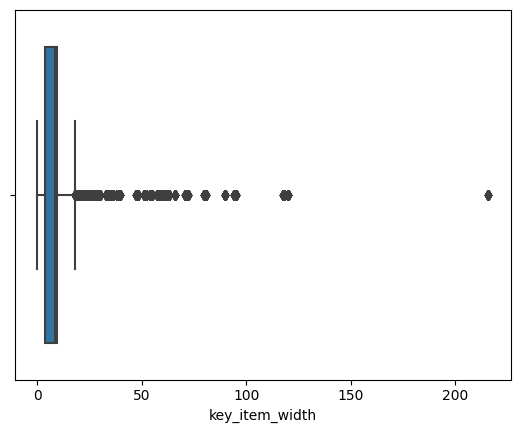

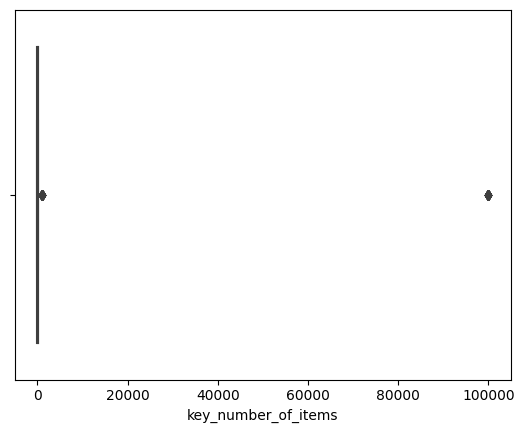

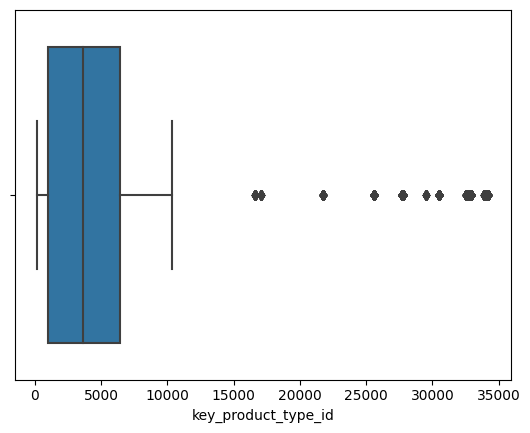

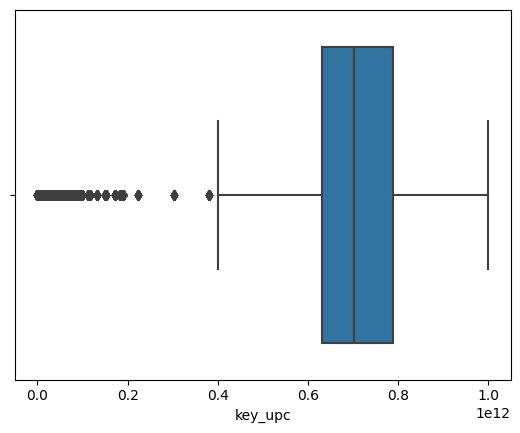

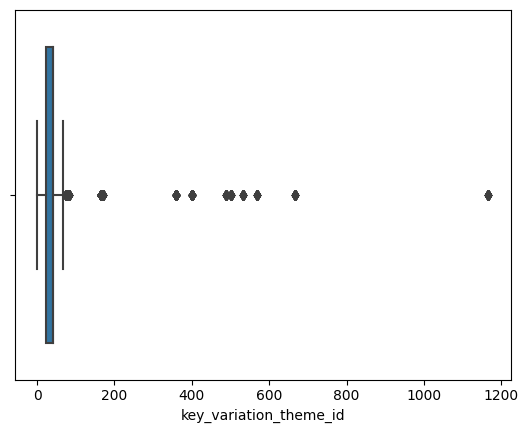

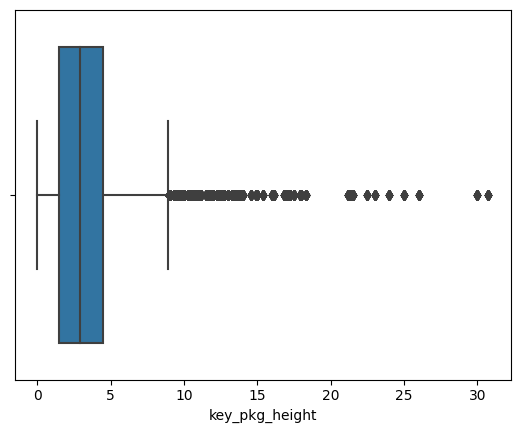

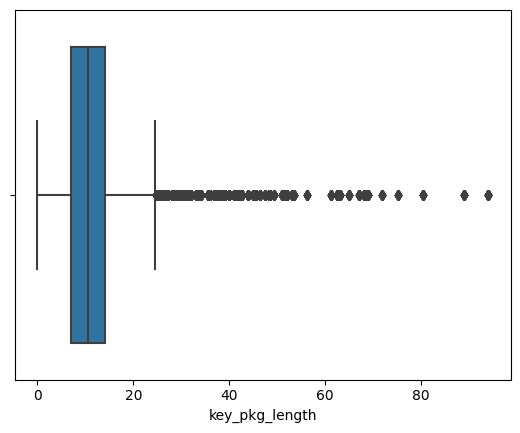

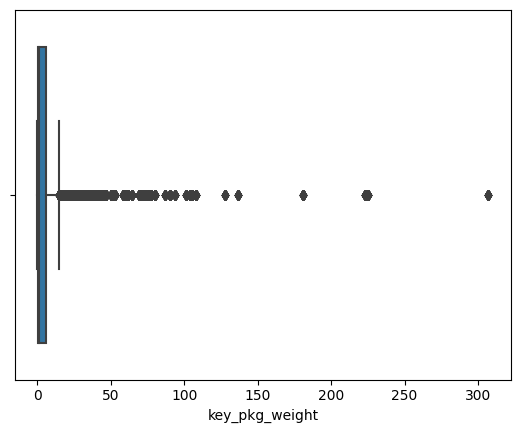

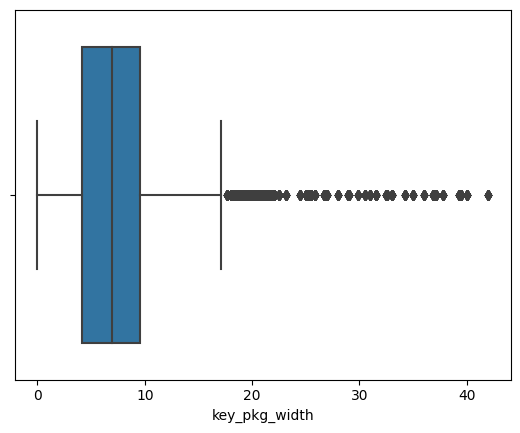

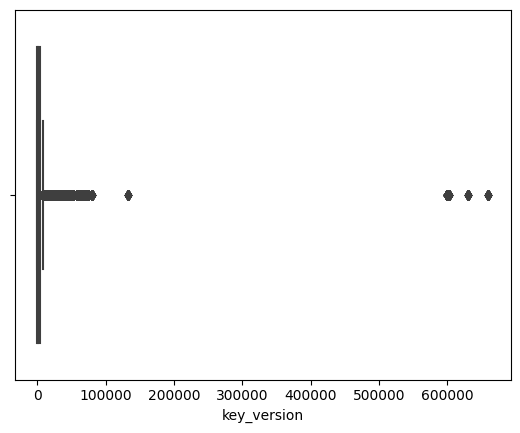

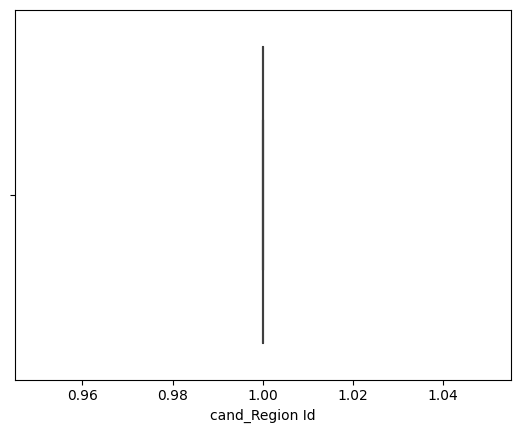

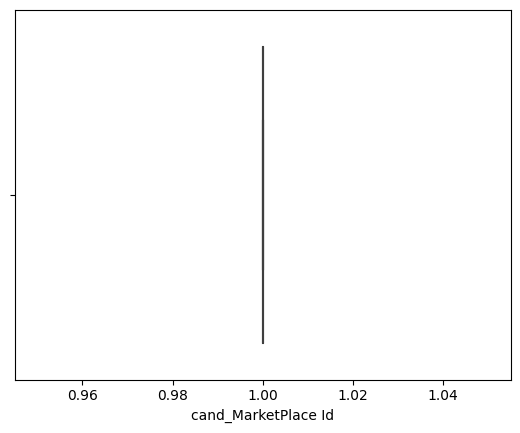

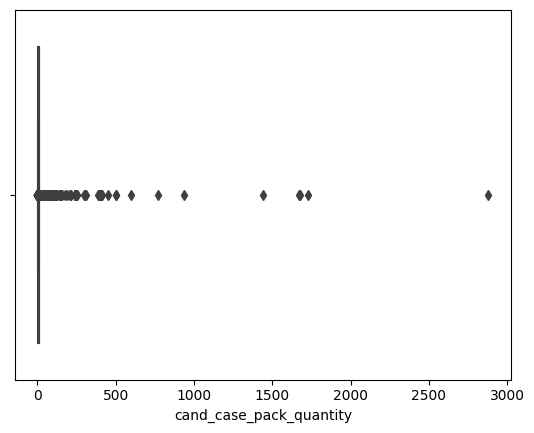

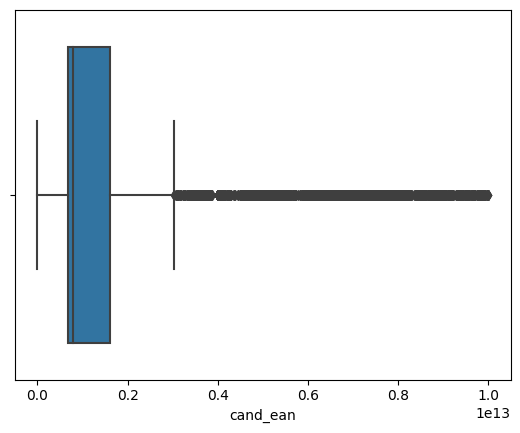

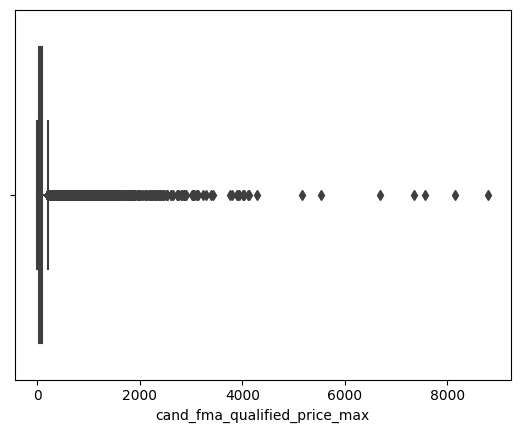

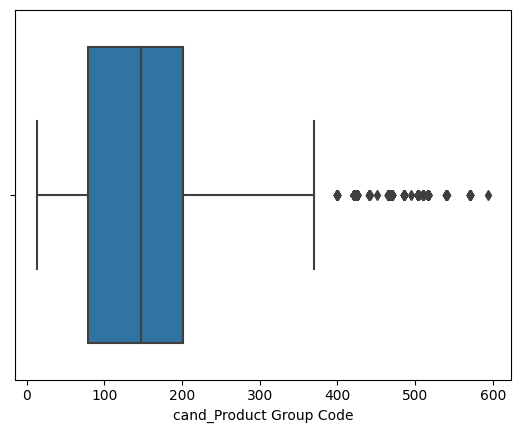

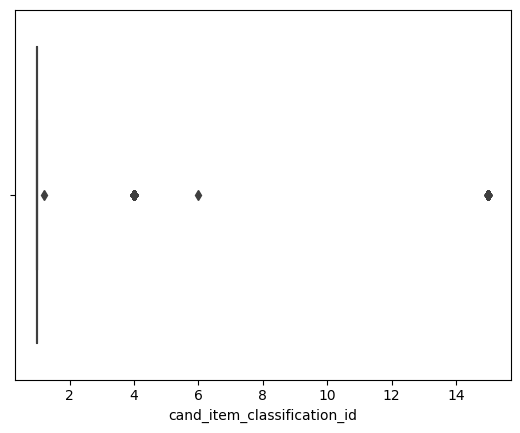

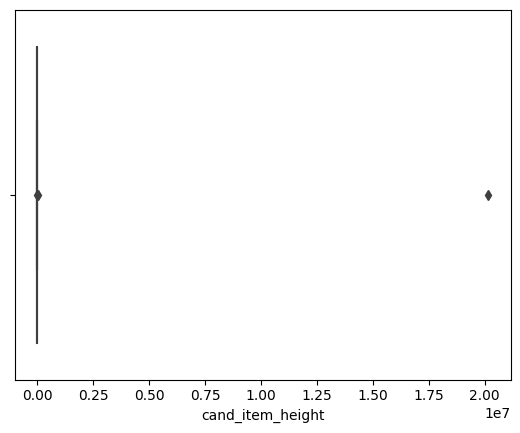

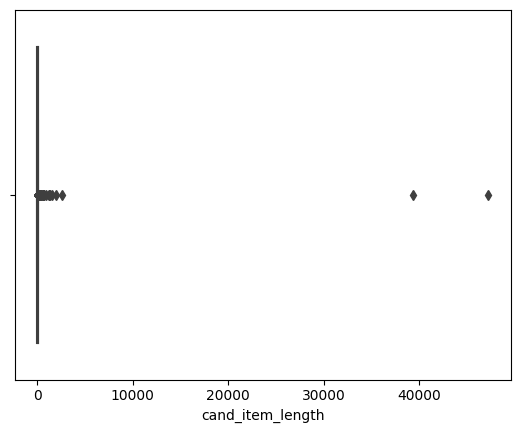

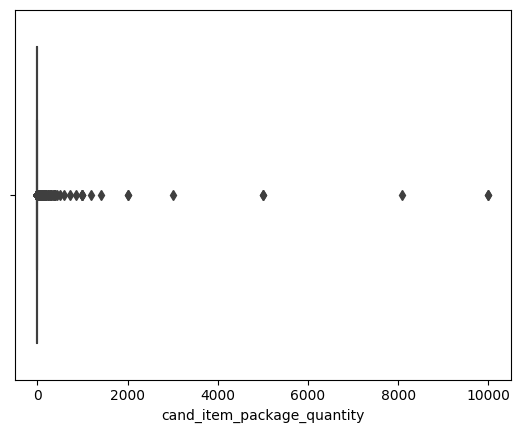

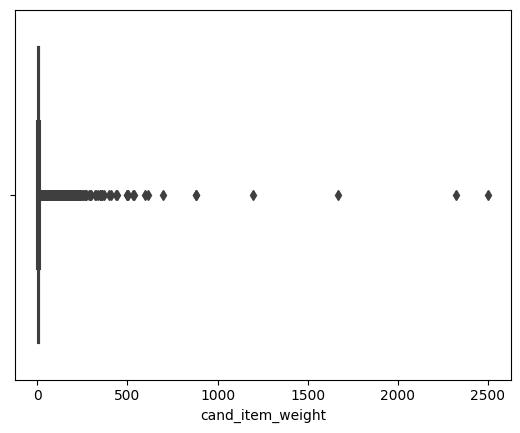

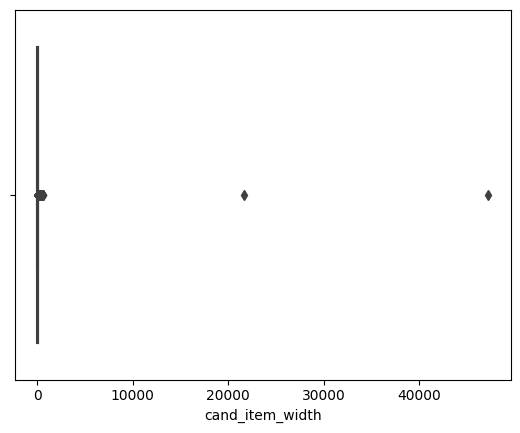

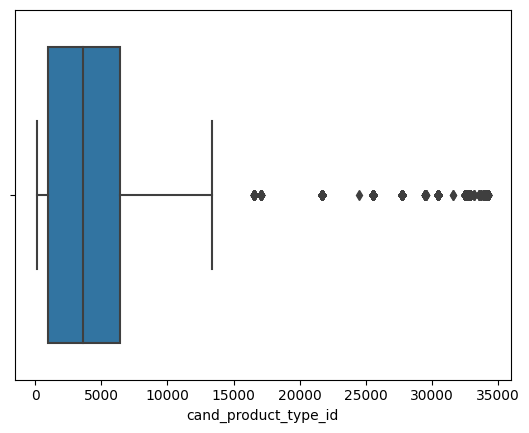

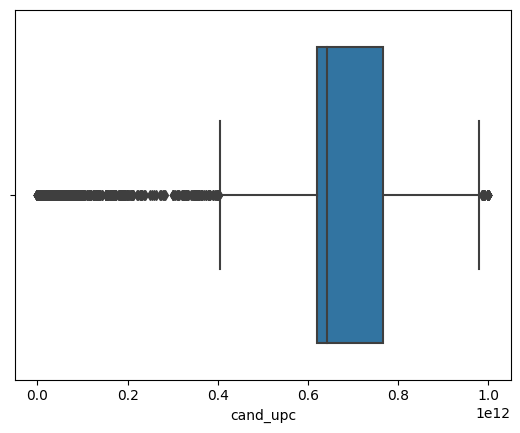

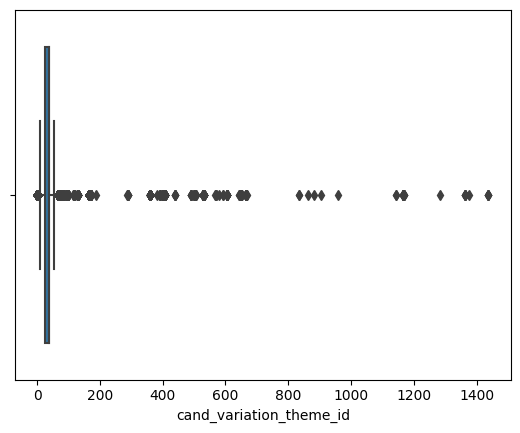

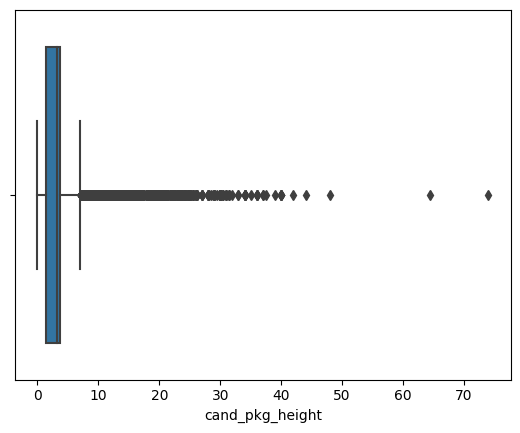

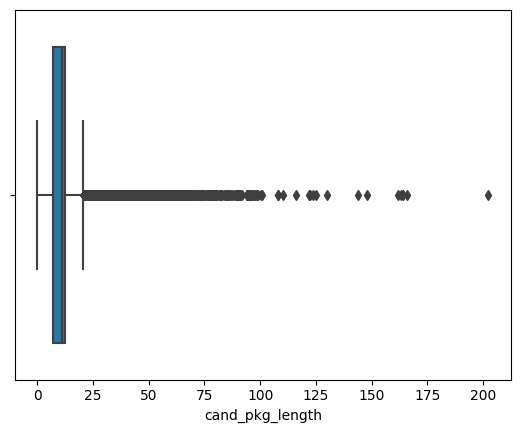

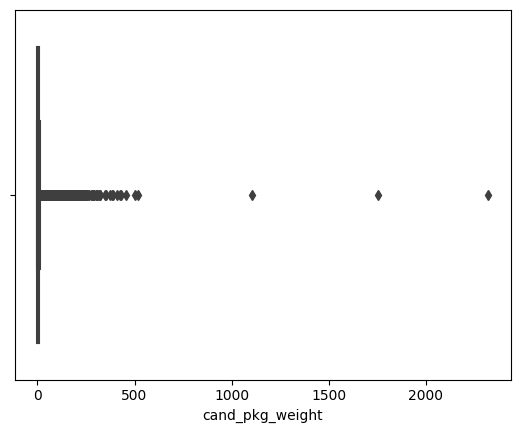

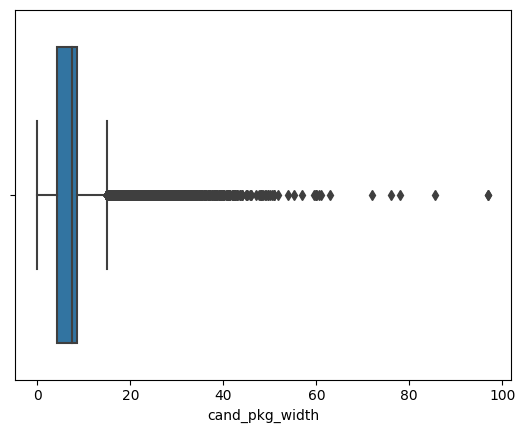

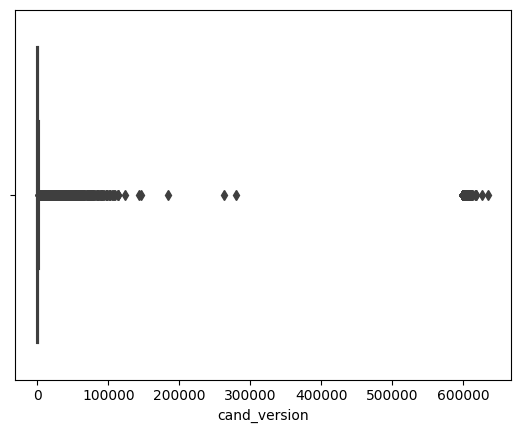

In [13]:
#Boxplots for numerical columns
for col in numerical_cols:
    sns.boxplot(data=train_df,x=col)
    plt.show()

In [14]:
# Calculate Quartiles
Q1 = train_df[numerical_cols].quantile(0.25)
Q3 = train_df[numerical_cols].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define Thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify Outliers
outliers = ((train_df[numerical_cols] < lower_bound) | (train_df[numerical_cols] > upper_bound)).any(axis=1)

# Remove Outliers
train_df = train_df[~outliers]

# Check the shape after removing outliers
print("Shape after removing outliers:", train_df.shape)

Shape after removing outliers: (3506, 109)


In [15]:
# Normalization using Min-Max scaling
scaler = MinMaxScaler()
train_df[numerical_cols] = scaler.fit_transform(train_df[numerical_cols])

In [16]:
# Splitting the dataset into features and target variable
X = train_df.drop(columns=['ID', 'label'])
y = train_df['label']

In [17]:
# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
X_train.dtypes.unique()

array([dtype('float64'), dtype('int32')], dtype=object)

In [19]:
X_train['key_creation_date'] = pd.to_numeric(X_train['key_creation_date'])

**Initialize and train the models**

In [20]:
# Logistic Regression
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train, y_train)

c:\users\riyam\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [21]:
# Predictions
y_pred_train_lr = logistic_regression_model.predict(X_train)

In [22]:
# Print training accuracy and classification report
print("Training Accuracy (Logistic Regression):", accuracy_score(y_train, y_pred_train_lr))
print("Classification Report (Logistic Regression):\n", classification_report(y_train, y_pred_train_lr))

Training Accuracy (Logistic Regression): 0.5452924393723253
Classification Report (Logistic Regression):
               precision    recall  f1-score   support

         0.0       0.54      0.50      0.52      1385
         1.0       0.55      0.58      0.57      1419

    accuracy                           0.55      2804
   macro avg       0.55      0.54      0.54      2804
weighted avg       0.55      0.55      0.54      2804



In [23]:
#Random Forest
randomf_model = RandomForestClassifier()
randomf_model.fit(X_train, y_train)

RandomForestClassifier()

In [24]:
# Predictions
y_pred = randomf_model.predict(X_train)

In [25]:
# Predict on training data for evaluation (you should use cross-validation for proper evaluation)
print("Training Accuracy:", accuracy_score(y_train, y_pred))
print("Classification Report:\n", classification_report(y_train, y_pred))

Training Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1385
         1.0       1.00      1.00      1.00      1419

    accuracy                           1.00      2804
   macro avg       1.00      1.00      1.00      2804
weighted avg       1.00      1.00      1.00      2804



In [26]:
train_df.shape

(3506, 109)

**Predictions on the Test Dataset**

In [27]:
#Reading testing dataset file
test_df=pd.read_csv('public_test_features.csv')
test_df.head()

C:\Users\riyam\AppData\Local\Temp\ipykernel_5932\1139797951.py:2: DtypeWarning: Columns (134,138,156,197,211) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df=pd.read_csv('public_test_features.csv')


ID  key_Region Id  key_MarketPlace Id    key_ASIN  \
0  35057              1                   1  B0096M8VR2   
1  41573              1                   1  B00EAQJCWW   
2  44029              1                   1  B013P93YOQ   
3   6462              1                   1  B00SKJPKGW   
4  17533              1                   1  B001DCEKXM   

           key_Binding Code   key_binding_description key_brand_code  \
0                        pc        Personal Computers            NaN   
1                   kitchen                   Kitchen          BUNN9   
2                       toy                       Toy            NaN   
3  wireless_phone_accessory  Wireless Phone Accessory          PIQ22   
4                    sports                    Sports          SUUNR   

   key_case_pack_quantity key_classification_code  \
0                     1.0            base_product   
1                     2.0            base_product   
2                     NaN            base_product   
3                     1.0            base_product   
4                     1.0            base_product   

  key_classification_description  ... cand_pkg_weight  cand_pkg_weight_uom  \
0                   Base Product  ...        0.925932               pounds   
1                   Base Product  ...             NaN                  NaN   
2                   Base Product  ...             NaN                  NaN   
3                   Base Product  ...        6.250000               pounds   
4                   Base Product  ...        0.176368               pounds   

  cand_pkg_width cand_release_date_embargo_level cand_dw_creation_date  \
0       5.826772                             NaN             10-Apr-13   
1            NaN                             NaN             17-Mar-16   
2            NaN                             NaN             23-Dec-15   
3       9.700000                             NaN             22-Jan-15   
4       3.228346                             NaN              4-Jan-11   

  cand_dw_last_updated cand_is_deleted cand_last_updated  cand_version  \
0             5-Jul-16               N          4-Jul-16           699   
1            17-Mar-16               N         17-Mar-16             2   
2             2-Dec-17               N          2-Dec-17            17   
3            18-Jan-17               N         18-Jan-17         25351   
4            16-Nov-17               N         16-Nov-17          7424   

   cand_external_testing_certification  
0                                  NaN  
1                                  NaN  
2                                  NaN  
3                                  NaN  
4                                  NaN  

[5 rows x 227 columns]

**Data Description**

In [28]:
test_df.shape

(15774, 227)

In [29]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15774 entries, 0 to 15773
Columns: 227 entries, ID to cand_external_testing_certification
dtypes: float64(88), int64(11), object(128)
memory usage: 27.3+ MB


**DATA PREPROCESSING**

In [30]:
test_df.isnull().sum().sort_values()

ID                                  0
key_last_updated                    0
key_is_deleted                      0
key_dw_last_updated                 0
key_dw_creation_date                0
                                ...  
key_manufacturer_sku            15774
key_preferred_vendor            15774
key_number_of_pages             15774
key_monthly_recurring_charge    15774
key_number_of_points            15774
Length: 227, dtype: int64

In [31]:
#Dropping columns with all missing values
test_df = test_df.dropna(axis=1, how='all')

In [32]:
# Dropping columns with too many missing values (threshold can be adjusted)
missing_threshold=0.7 #70% missing values threshold
threshold = len(test_df) * (1 - missing_threshold)
test_df=test_df.dropna(thresh=threshold, axis=1)

In [33]:
# Fill missing values in remaining columns (numerical columns with mean, categorical columns with mode)
numerical_cols=test_df.select_dtypes(include=['float64']).columns
categorical_cols=test_df.select_dtypes(include=['object']).columns

test_df[numerical_cols] = test_df[numerical_cols].fillna(test_df[numerical_cols].mean())
test_df[categorical_cols] = test_df[categorical_cols].fillna(test_df[categorical_cols].mode().iloc[0])

In [34]:
# Encode categorical variables using Label Encoder
label_encoder = LabelEncoder()
test_df.loc[:, categorical_cols] = test_df.loc[:, categorical_cols].apply(label_encoder.fit_transform)

C:\Users\riyam\AppData\Local\Temp\ipykernel_5932\535037824.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_df.loc[:, categorical_cols] = test_df.loc[:, categorical_cols].apply(label_encoder.fit_transform)


In [35]:
# Drop unnecessary columns
unnecessary_columns = ['key_ASIN', 'key_Binding Code', 'key_classification_description', 'cand_ASIN', 'cand_Binding Code', 'cand_classification_description']
test_df = test_df.drop(columns=unnecessary_columns)

In [36]:
#Checking for missing values
missing_values = test_df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 ID                         0
key_Region Id              0
key_MarketPlace Id         0
key_binding_description    0
key_brand_code             0
                          ..
cand_dw_creation_date      0
cand_dw_last_updated       0
cand_is_deleted            0
cand_last_updated          0
cand_version               0
Length: 108, dtype: int64


In [37]:
# Check for outliers in numerical columns
numerical_cols = test_df.select_dtypes(include=['float64', 'int64']).columns
numerical_data = test_df[numerical_cols]
numerical_summary = numerical_data.describe()
print("Numerical Summary:\n", numerical_summary)

Numerical Summary:
                  ID  key_Region Id  key_MarketPlace Id  \
count  15774.000000        15774.0             15774.0   
mean   26163.192152            1.0                 1.0   
std    15220.590579            0.0                 0.0   
min        0.000000            1.0                 1.0   
25%    12847.750000            1.0                 1.0   
50%    26224.000000            1.0                 1.0   
75%    39360.750000            1.0                 1.0   
max    52571.000000            1.0                 1.0   

       key_case_pack_quantity       key_ean  key_fma_qualified_price_max  \
count            15774.000000  1.577400e+04                 15774.000000   
mean                 9.655313  1.694087e+12                   117.616536   
std                 46.287573  2.271668e+12                   264.364729   
min                  0.000000  1.427901e+07                    10.170000   
25%                  2.000000  6.617990e+11                    26.390000   
5

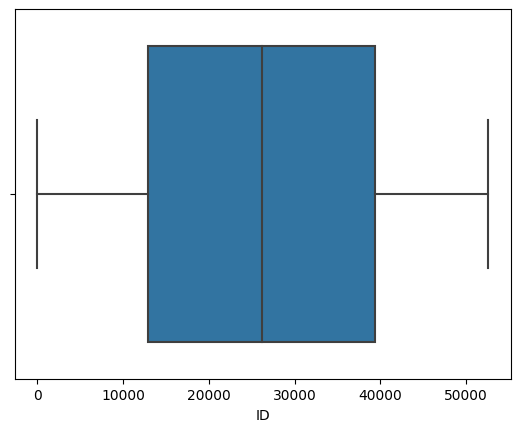

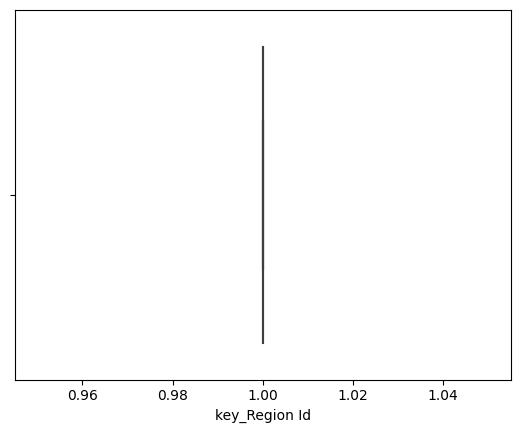

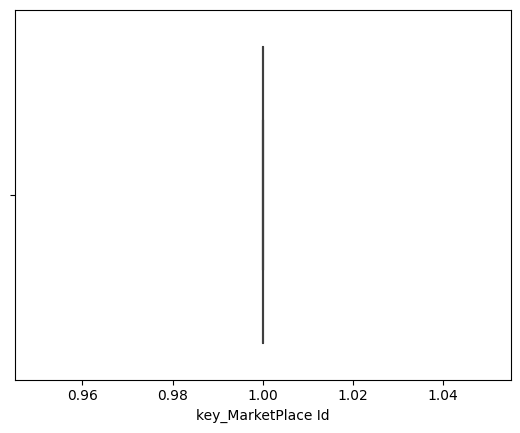

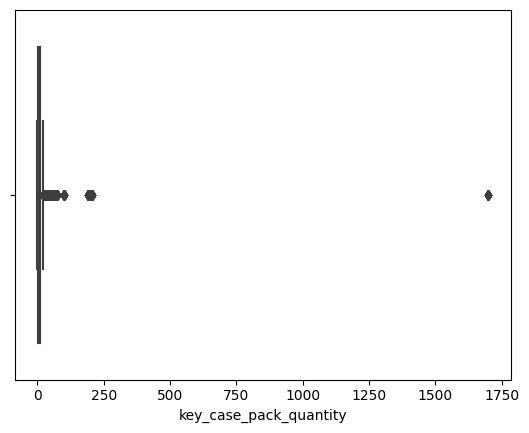

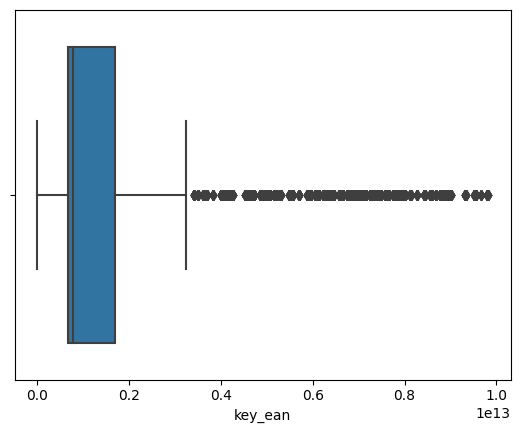

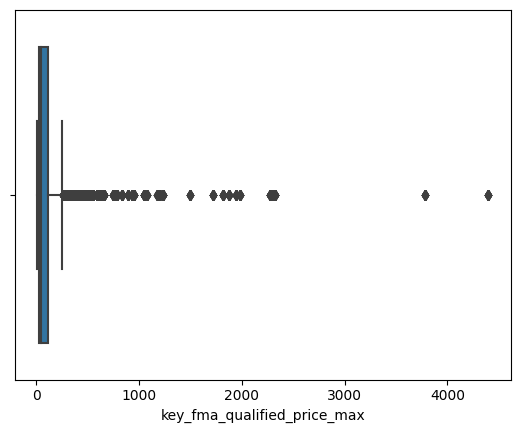

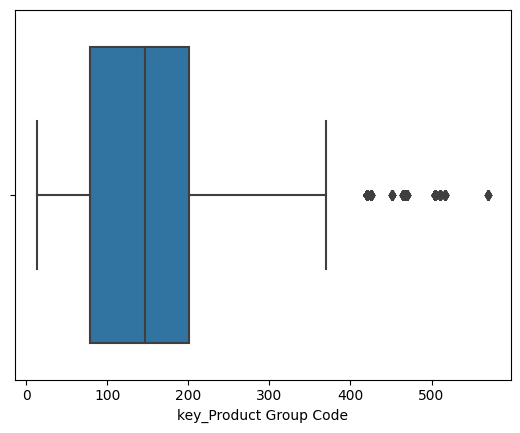

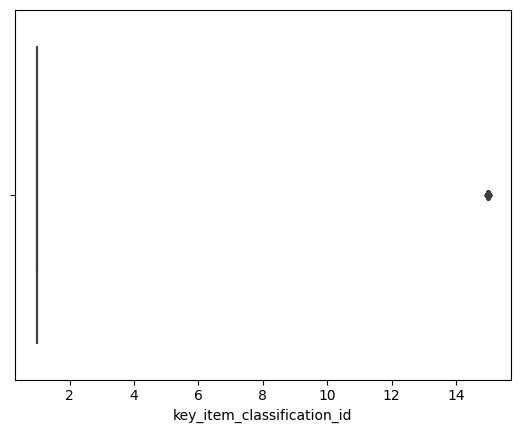

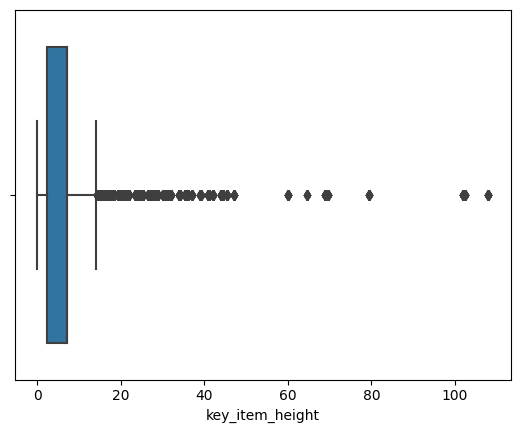

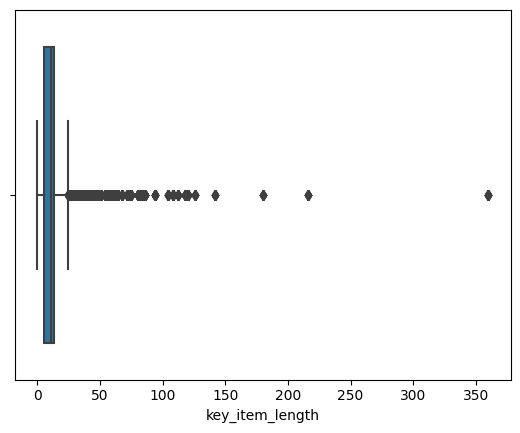

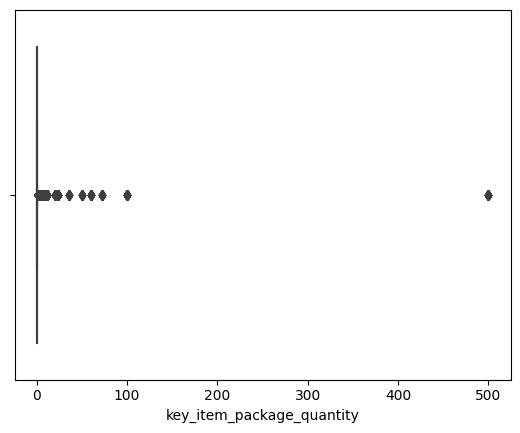

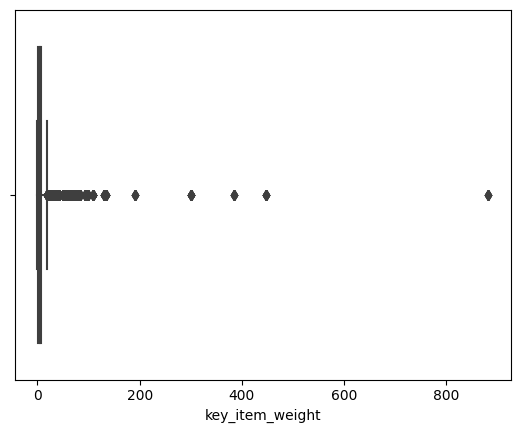

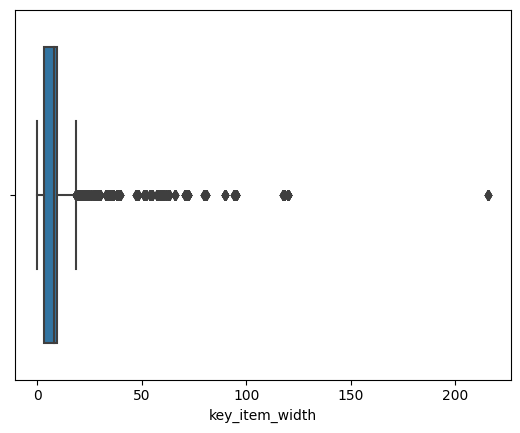

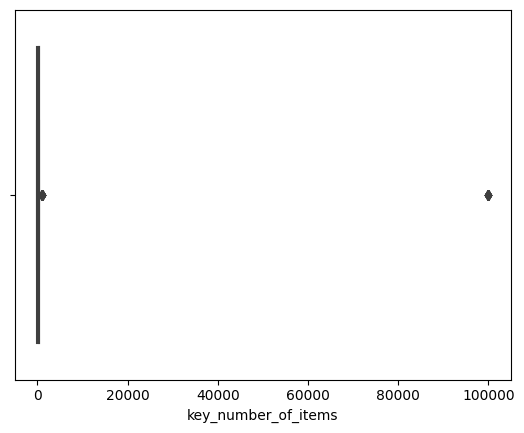

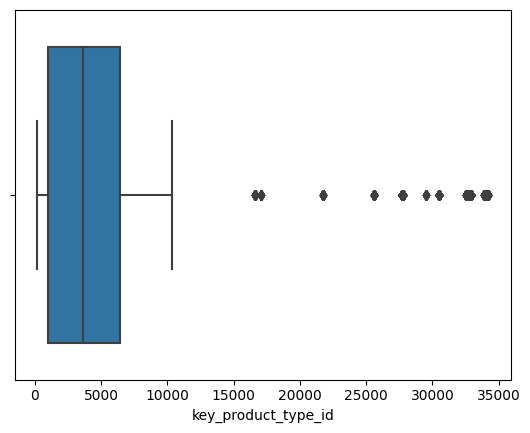

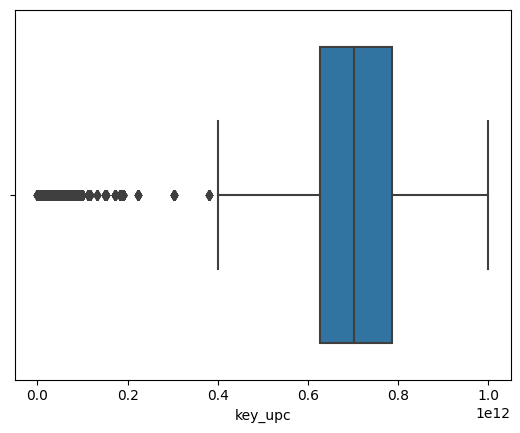

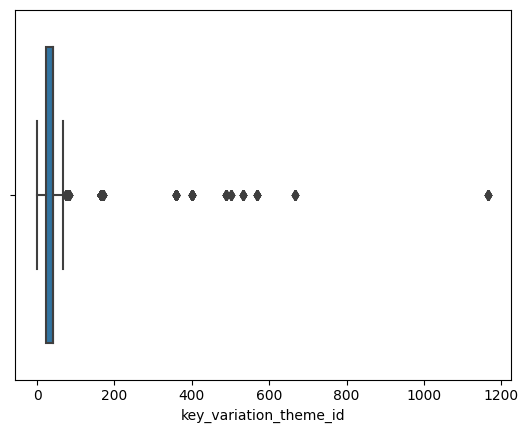

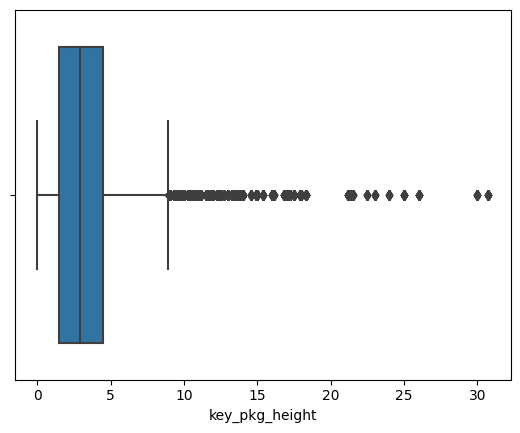

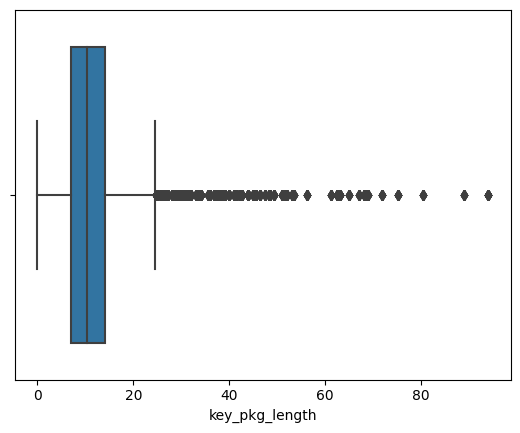

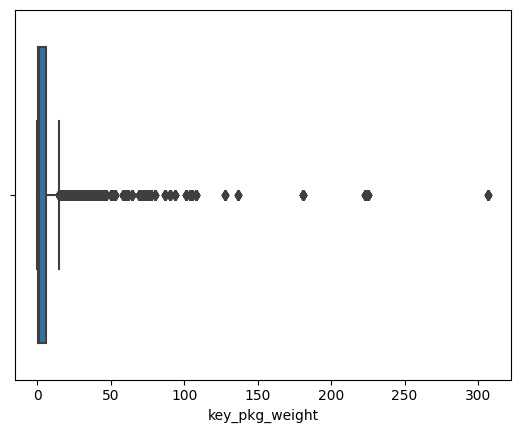

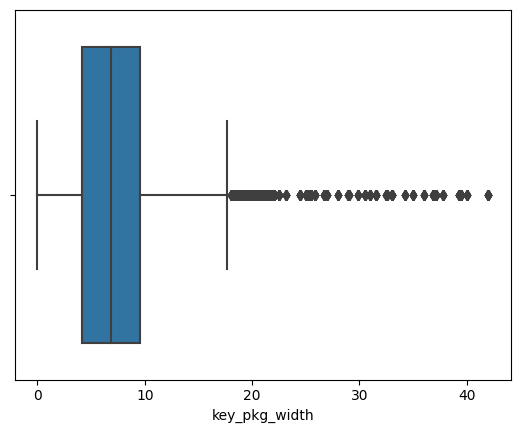

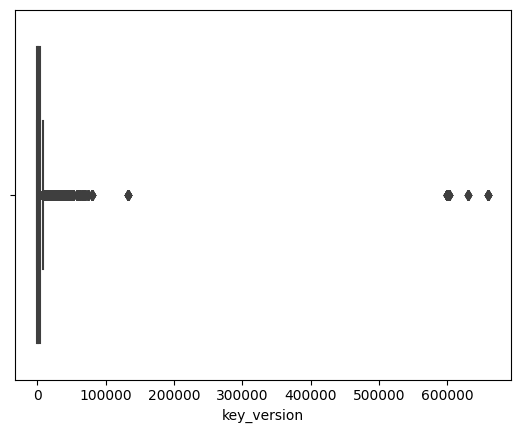

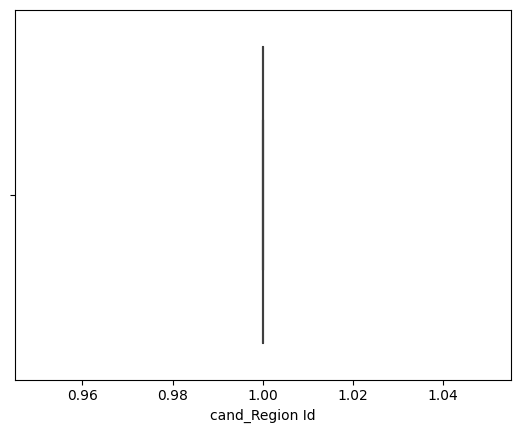

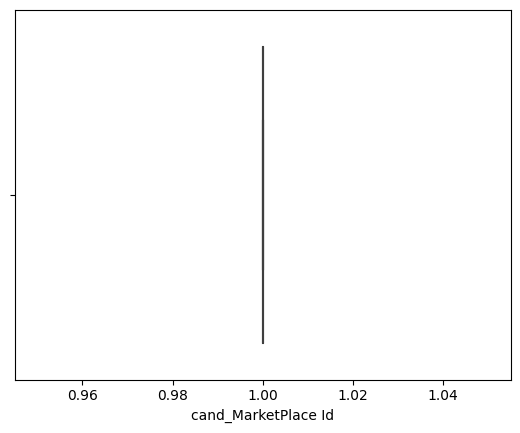

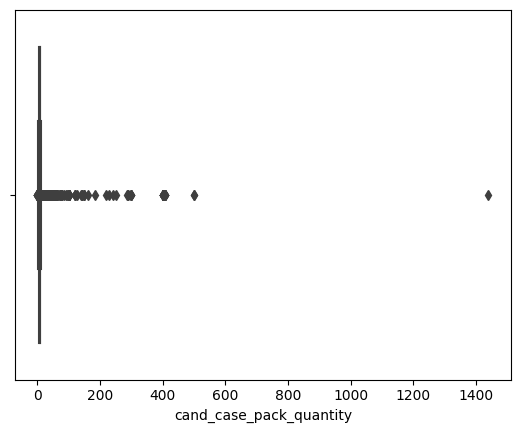

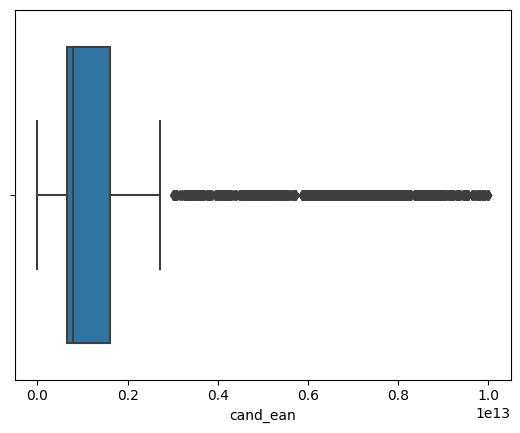

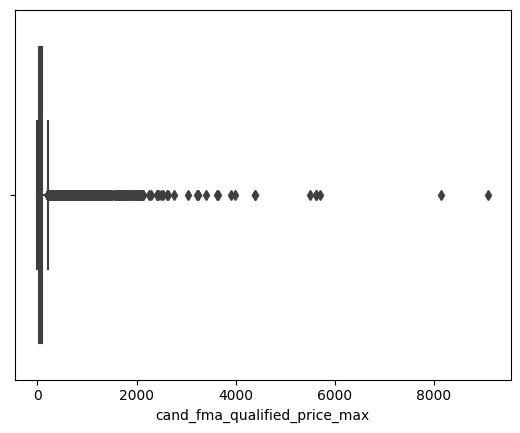

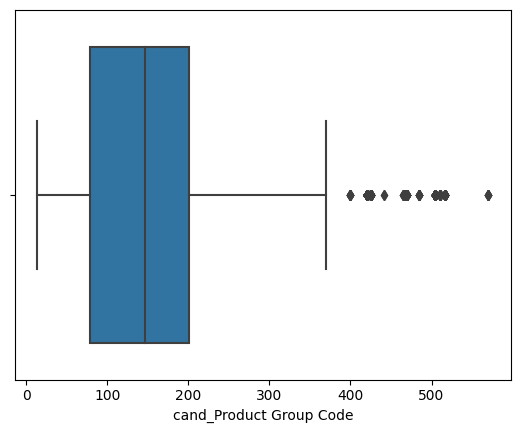

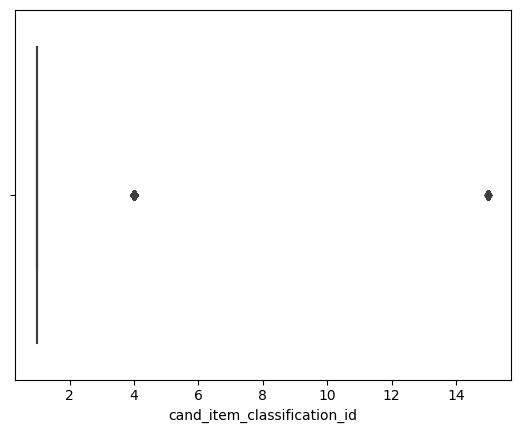

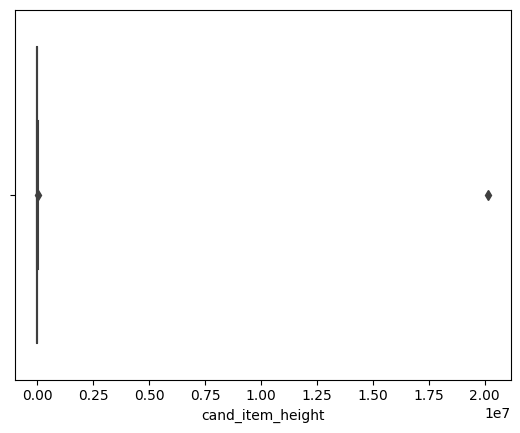

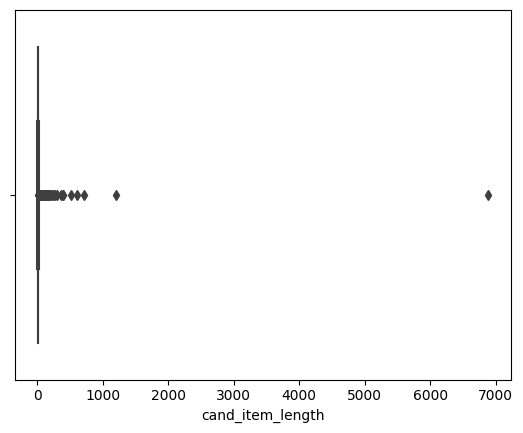

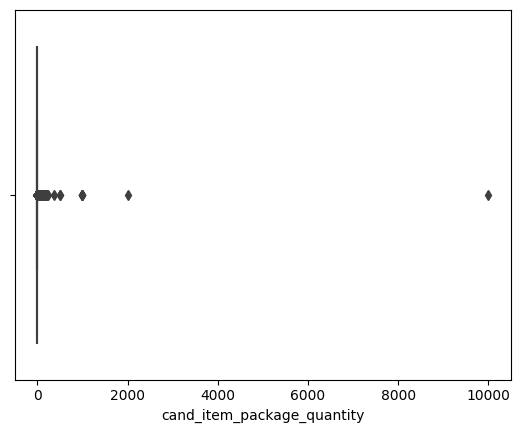

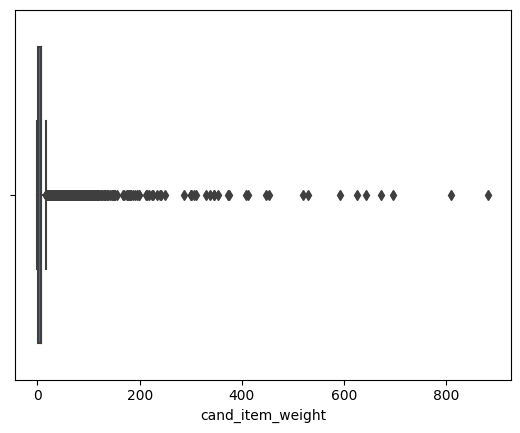

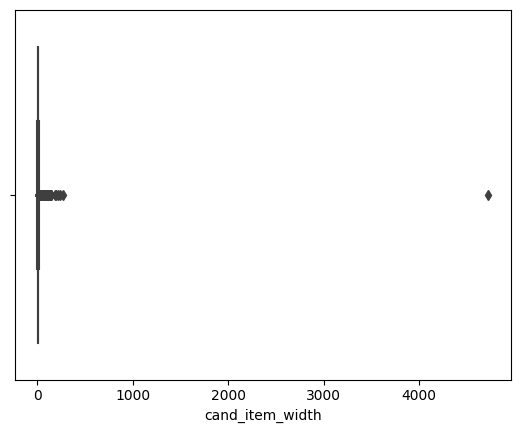

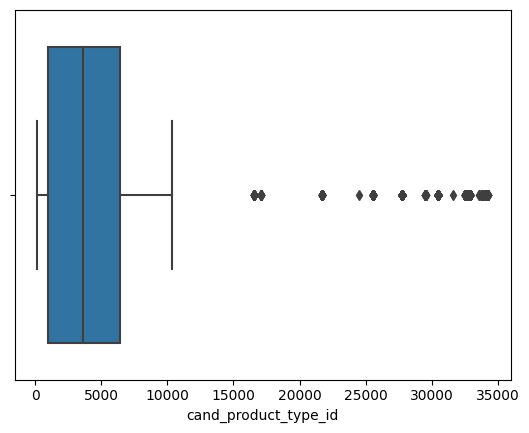

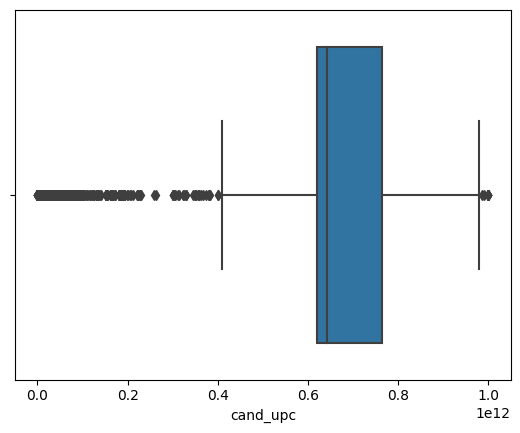

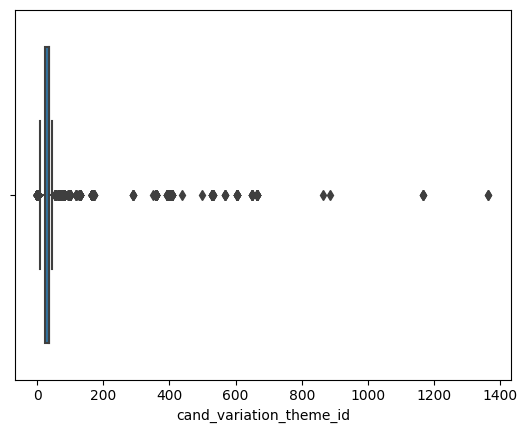

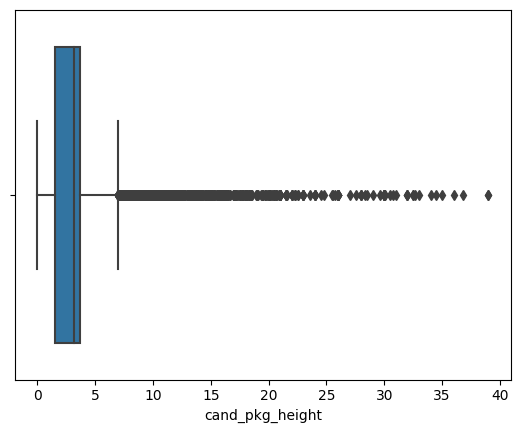

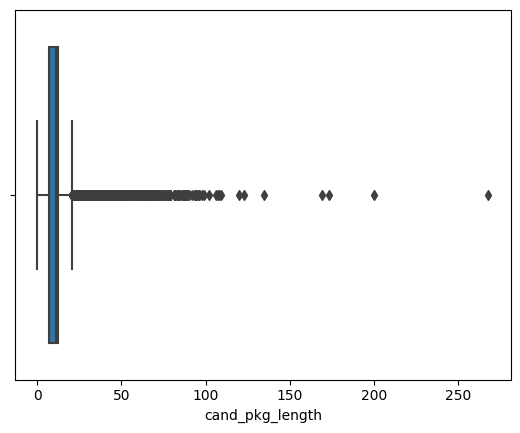

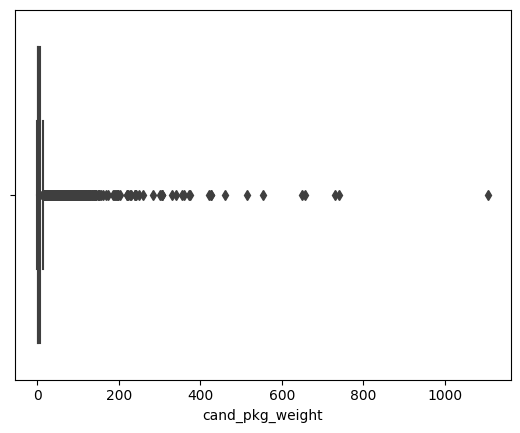

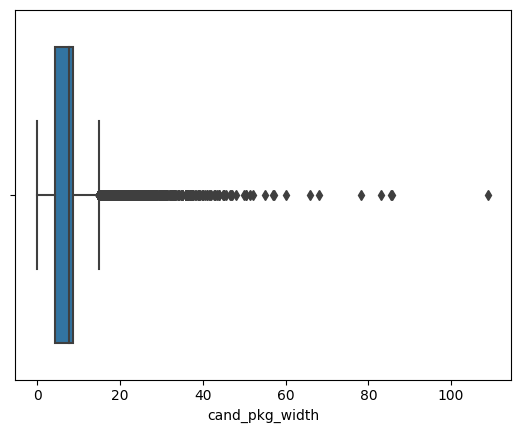

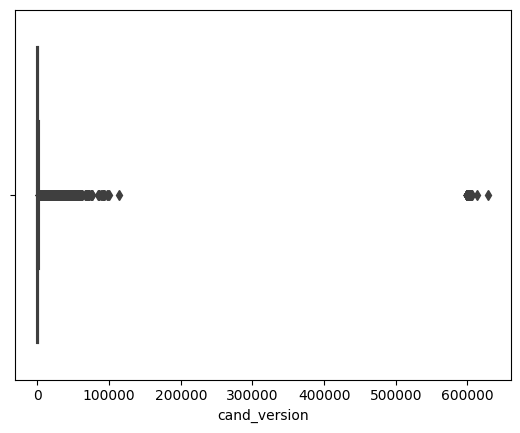

In [38]:
#Boxplots for numerical columns
for col in numerical_cols:
    sns.boxplot(data=test_df,x=col)
    plt.show()

In [39]:
test_df.shape

(15774, 108)

In [40]:
# Calculate Quartiles
Q1 = test_df[numerical_cols].quantile(0.25)
Q3 = test_df[numerical_cols].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define Thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify Outliers
outliers = ((test_df[numerical_cols] < lower_bound) | (test_df[numerical_cols] > upper_bound)).any(axis=1)

# Remove Outliers
test_df = test_df[~outliers]

# Check the shape after removing outliers
print("Shape after removing outliers:", test_df.shape)

Shape after removing outliers: (1524, 108)


In [41]:
# Normalization using Min-Max scaling
scaler = MinMaxScaler()
test_df[numerical_cols] = scaler.fit_transform(test_df[numerical_cols])

In [42]:
#Prediction for testing dataset using Logistic regression
test_predictions1 = logistic_regression_model.predict(test_df.drop(columns=['ID']))

In [43]:
#Prediction for testing dataset using random forest
test_predictions2 = randomf_model.predict(test_df.drop(columns=['ID']))